In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import slack_notification as sn

In [2]:
%matplotlib inline

In [3]:
gen_img = cv2.imread("./val/label/0a0119288.jpg", 0)
_, gen_img = cv2.threshold(gen_img, 127, 1, cv2.THRESH_BINARY)

In [80]:
_, contours, _ = cv2.findContours(gen_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [81]:
img0 = np.zeros_like(gen_img)

In [82]:
img = cv2.drawContours(img0, contours, -1, 1, cv2.CHAIN_APPROX_SIMPLE)

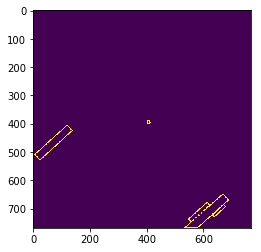

In [83]:
plt.imshow(img)

In [84]:
np.max(gen_img)

1

In [4]:
def  approximate_img(_img, eps):
    _img = np.array(_img, dtype='uint8')
    _, contours, _ = cv2.findContours(_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    result_img = np.zeros_like(_img)
    for cnt in contours:
        epsilon = eps*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        result_img = cv2.fillConvexPoly(result_img, approx, 1)
    return result_img

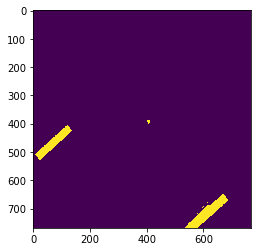

In [91]:
plt.imshow(approximate_img(gen_img, 0.03))

In [5]:
def  approximate_img2(_img):
    _img = np.array(_img, dtype='uint8')
    _, contours, _ = cv2.findContours(_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    result_img = np.zeros_like(_img)
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        result_img = cv2.fillConvexPoly(result_img, box, 1)
    return result_img

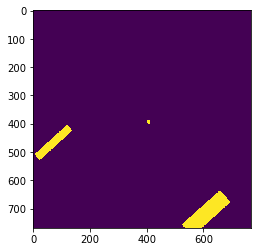

In [88]:
plt.imshow(approximate_img2(gen_img))

In [3]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
"""
ランレングス記法のデータを白黒画像に直す
"""
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    #nan check
    if mask_rle != mask_rle:
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        return img.reshape(shape).T
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [4]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [9]:
df = pd.read_csv("./csv/submission_0813_1.csv")

In [93]:
def make_new_csv():
    index = 0
    df_dst = pd.DataFrame({'ImageId': [], 'EncodedPixels1': [], 'EncodedPixels2': [], 'EncodedPixels3': []})
    df_dst = df_dst[['ImageId', 'EncodedPixels1', 'EncodedPixels2', 'EncodedPixels3']]
    for i in range(len(df)):
        encoded = df['EncodedPixels'][i]
        if encoded == encoded:
            mask_img = rle_decode(encoded)
            _, mask_img = cv2.threshold(mask_img, 0.5, 1, cv2.THRESH_BINARY)
            result_img1 = approximate_img(mask_img, 0.021)
            result_img2 = approximate_img2(mask_img)
            result_img3 = approximate_img(mask_img, 0.026)
            rl1 = rle_encode(result_img1)
            rl2 = rle_encode(result_img2)
            rl3 = rle_encode(result_img3)
            df_dst.loc[index] = [df['ImageId'][i], rl1, rl2, rl3]
            index += 1
        else:
            df_dst.loc[index] = [df['ImageId'][i], "", "", ""]
            index += 1
        if i % 5000 == 0:
            print(i)
            sn.send_notification(text='convert: {}'.format(i))
            df_dst.to_csv('submission_0811_1.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels1'])
            df_dst.to_csv('submission_0811_2.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels2'])
            df_dst.to_csv('submission_0811_3.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels3'])
    sn.send_notification(text='complete')
    df_dst.to_csv('submission_0811_1.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels1'])
    df_dst.to_csv('submission_0811_2.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels2'])
    df_dst.to_csv('submission_0811_3.csv', header=True, index=False, columns=['ImageId', 'EncodedPixels3'])

In [94]:
make_new_csv()

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000


In [5]:
df = pd.read_csv("./csv/submission_0813_2.csv")

In [6]:
def make_separate_csv():
    index = 0
    df_dst = pd.DataFrame({'ImageId': [], 'EncodedPixels': []})
    df_dst = df_dst[['ImageId', 'EncodedPixels']]
    for i in range(len(df)):
        encoded = df['EncodedPixels'][i]
        if encoded == encoded:
            mask_img = rle_decode(encoded)
            labels_num, labeled_img = cv2.connectedComponents(mask_img)
            for j in range(1, labels_num):
                separate = np.zeros((768, 768))
                separate[labeled_img == j] = 1
                rl = rle_encode(separate)
                df_dst.loc[index] = [df['ImageId'][i], rl]
                index += 1
        else:
            df_dst.loc[index] = [df['ImageId'][i], ""]
            index += 1
        if i % 5000 == 0:
            print(i)
            sn.send_notification(text='convert: {}'.format(i))
            df_dst.to_csv('./csv/submission_0813_2_separate.csv', header=True, index=False)
    sn.send_notification(text="complete")
    df_dst.to_csv('./csv/submission_0813_2_separate.csv', header=True, index=False)

In [ ]:
make_separate_csv()

0
5000
10000
